In [1]:
import torch
from torch import nn, Tensor
import math
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pandas import to_datetime
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
import gc
import tqdm
import matplotlib.pyplot as plt

In [2]:
kepco = pd.read_csv('kepcoTotal.csv')

In [3]:
kepco.head(5)

,Hourly Time,Hourly Sum
0,2015년 10월 1일 00시,557904.3242
1,2015년 10월 1일 01시,537670.6250
2,2015년 10월 1일 02시,524698.2930
3,2015년 10월 1일 03시,517785.5781
4,2015년 10월 1일 04시,518839.8789


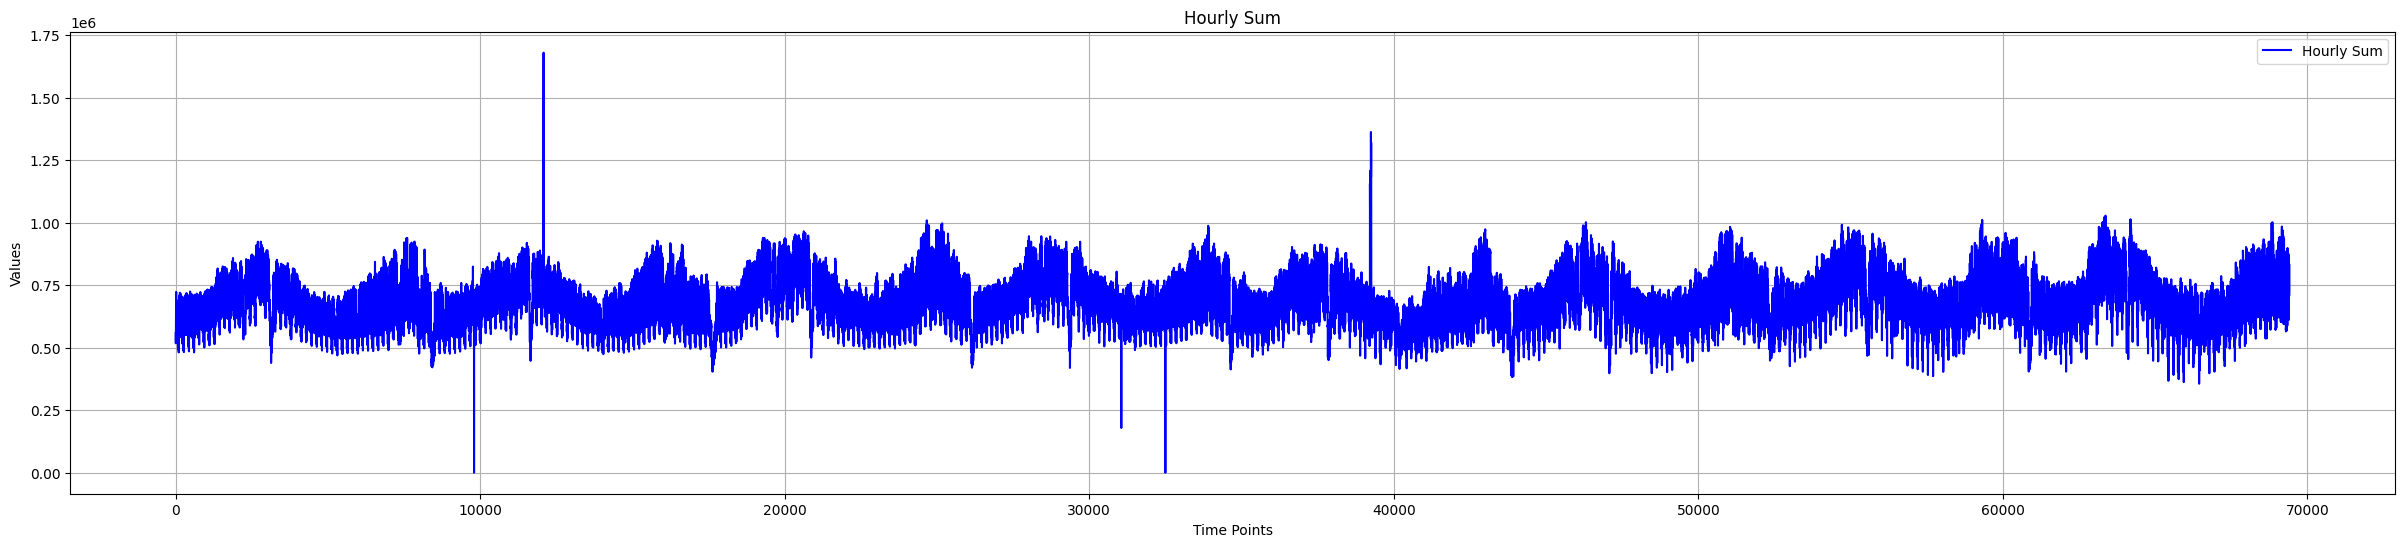

In [5]:
plt.figure(figsize=(30, 6))
plt.plot(kepco['Hourly Sum'], label='Hourly Sum', color='blue')

plt.title('Hourly Sum')
plt.xlabel('Time Points')
plt.ylabel('Values')
plt.legend()

plt.grid(True)
plt.show()

In [6]:
print('number of data(kepco) : ',len(kepco))

number of data(kepco) :  69408


In [7]:
#'Hourly Time'을 datetime 객체로 변환
kepco['Hourly Time'] = pd.to_datetime(kepco['Hourly Time'], format='%Y년 %m월 %d일 %H시')

#추가적인 시간 관련 특징을 추출
kepco['weekday'] = kepco['Hourly Time'].dt.dayofweek 
kepco['hour'] = kepco['Hourly Time'].dt.hour         
kepco['month'] = kepco['Hourly Time'].dt.month
kepco.head(5)

,Hourly Time,Hourly Sum,weekday,hour,month
0,2015-10-01 00:00:00,557904.3242,3,0,10
1,2015-10-01 01:00:00,537670.6250,3,1,10
2,2015-10-01 02:00:00,524698.2930,3,2,10
3,2015-10-01 03:00:00,517785.5781,3,3,10
4,2015-10-01 04:00:00,518839.8789,3,4,10


In [8]:
#이상치 제거
Q1 = kepco['Hourly Sum'].quantile(0.25)
Q3 = kepco['Hourly Sum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [9]:
#이상치 제거 반영
median = kepco['Hourly Sum'].median()
kepco.loc[(kepco['Hourly Sum'] < lower_bound) | (kepco['Hourly Sum'] > upper_bound), 'Hourly Sum'] = median

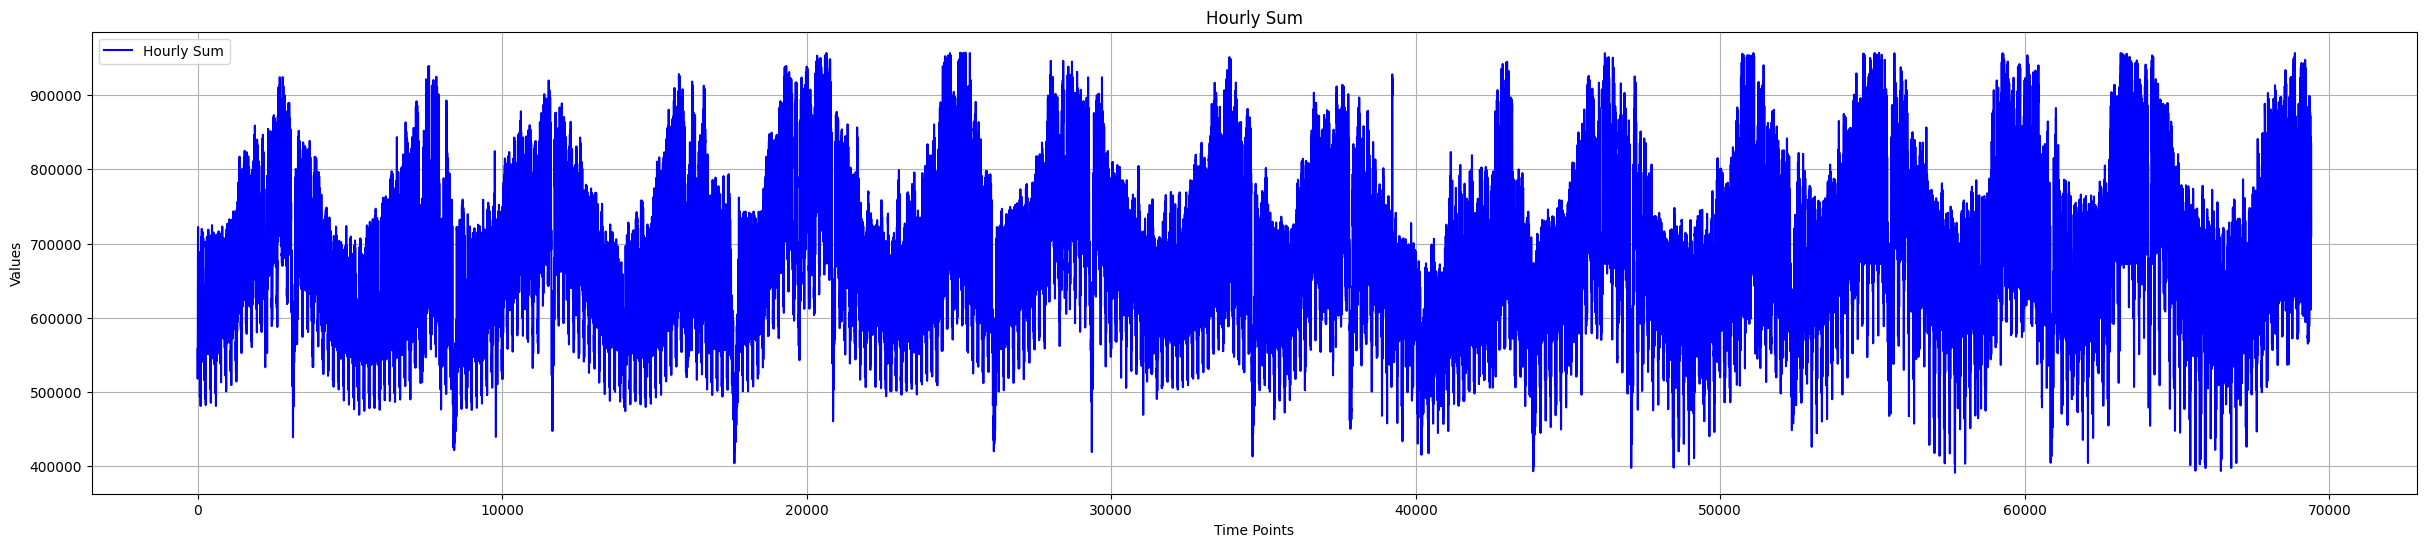

In [10]:
#이상치 제거후 데이터셋
plt.figure(figsize=(30, 6))
plt.plot(kepco['Hourly Sum'], label='Hourly Sum', color='blue')

plt.title('Hourly Sum')
plt.xlabel('Time Points')
plt.ylabel('Values')
plt.legend()

plt.grid(True)
plt.show()

In [11]:
#24시간 단위로 scaling하는 함수
def scale_in_chunks(data, chunk_size):
    scaled_data = []
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i + chunk_size]
        chunk_reshaped = chunk.reshape(-1, 1)
        if i == 0 or len(chunk) == chunk_size:
            scaled_chunk = scaler.fit_transform(chunk_reshaped)
        else:
            scaled_chunk = scaler.transform(chunk_reshaped)
        scaled_data.extend(scaled_chunk.flatten())
    return np.array(scaled_data)

In [13]:
#'Hourly Sum' 전력 사용량 데이터 정규화
scaler = StandardScaler()
hourly_sum = np.array(kepco['Hourly Sum'])
month = np.array(kepco['month'])
hour = np.array(kepco['hour'])

scaled_hourly_sum = scale_in_chunks(hourly_sum, 24)
scaled_month = scale_in_chunks(month, 24)
scaled_hour = scale_in_chunks(hour, 24)


kepco['Hourly Sum'] = scaled_hourly_sum
kepco['month'] = scaled_month
kepco['hour'] = scaled_hour

# 데이터 프레임에서 필요한 열만 선택
input_kepco = kepco[['Hourly Sum', 'month','hour']]
input_kepco.head()

,Hourly Sum,month,hour
0,-1.104510,0.0,-1.661325
1,-1.373351,0.0,-1.516862
2,-1.545711,0.0,-1.372399
3,-1.637559,0.0,-1.227936
4,-1.623550,0.0,-1.083473


In [14]:
train_kepco = input_kepco[:int(0.7*len(input_kepco))]
temp = input_kepco[int(0.7*len(input_kepco)):]
test_kepco =temp[int(len(temp)*0.5):] 
val_kepco = temp - temp[int(len(temp)*0.5):]
train_kepco.shape, test_kepco.shape

((48585, 3), (10412, 3))

In [15]:
sequence_length = 168  
prediction_length = 24  

# 시퀀스 데이터를 생성하는 함수
def create_sequences(kepco, sequence_length, prediction_length):
    X = []
    y = []

    for i in range(len(kepco) - sequence_length - prediction_length + 1):
        X.append(kepco[i:(i + sequence_length)].values)
        y.append(kepco[(i + sequence_length):(i + sequence_length + prediction_length)]['Hourly Sum'].values)

    X = np.array(X)
    y = np.array(y)

    return X, y

X_train, y_train = create_sequences(train_kepco, sequence_length, prediction_length)
X_val, y_val = create_sequences(val_kepco, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_kepco, sequence_length, prediction_length)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(48394, 168, 3) (48394, 24)
(20632, 168, 3) (20632, 24)
(10221, 168, 3) (10221, 24)


In [16]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, model_dim))
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=model_dim * 4, dropout=dropout,batch_first = True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(model_dim, output_dim)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.input_linear(x) + self.positional_encoding
        mask = self.generate_square_subsequent_mask(x.size(1)).to(x.device)
        x = self.transformer_encoder(x, mask)
        return self.output_linear(x[:, -1, :])

# 모델 인스턴스 생성
input_dim = X_train.shape[-1]  # 입력 차원
model_dim = 512  # 모델의 특징 차원
num_heads = 8  # 어텐션 헤드의 수
num_layers = 4  # 인코더 레이어의 수
output_dim = y_train.shape[-1]  # 출력 차원

model = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim)

# 손실 함수와 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 요약
model, criterion, optimizer

(TransformerModel(
   (input_linear): Linear(in_features=3, out_features=512, bias=True)
   (encoder_layer): TransformerEncoderLayer(
     (self_attn): MultiheadAttention(
       (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
     )
     (linear1): Linear(in_features=512, out_features=2048, bias=True)
     (dropout): Dropout(p=0.1, inplace=False)
     (linear2): Linear(in_features=2048, out_features=512, bias=True)
     (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
     (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
     (dropout1): Dropout(p=0.1, inplace=False)
     (dropout2): Dropout(p=0.1, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_fea

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TransformerModel(
  (input_linear): Linear(in_features=3, out_features=512, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_featur

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# PyTorch에서 사용할 데이터를 tensor로 변환
X_train_tensor = torch.Tensor(X_train).to(device)
y_train_tensor = torch.Tensor(y_train).to(device)
X_val_tensor = torch.Tensor(X_val).to(device)
y_val_tensor = torch.Tensor(y_val).to(device)

# TensorDataset과 DataLoader를 사용하여 데이터 로드
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [19]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    for epoch in range((num_epochs)):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target).item()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

In [20]:
# Run the training loop
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Epoch 1/30, Train Loss: 1.0995, Val Loss: 0.0041
Epoch 2/30, Train Loss: 0.6507, Val Loss: 0.4742
Epoch 3/30, Train Loss: 0.5090, Val Loss: 0.7406
Epoch 4/30, Train Loss: 0.4177, Val Loss: 0.7231
Epoch 5/30, Train Loss: 0.8987, Val Loss: 0.1725
Epoch 6/30, Train Loss: 1.0611, Val Loss: 0.0340
Epoch 7/30, Train Loss: 1.1365, Val Loss: 0.0831
Epoch 8/30, Train Loss: 0.9595, Val Loss: 0.0091
Epoch 9/30, Train Loss: 0.9301, Val Loss: 0.0102
Epoch 10/30, Train Loss: 0.9571, Val Loss: 0.0367
Epoch 11/30, Train Loss: 1.0340, Val Loss: 0.0092
Epoch 12/30, Train Loss: 0.9176, Val Loss: 0.0104
Epoch 13/30, Train Loss: 0.9271, Val Loss: 0.0208
Epoch 14/30, Train Loss: 1.0176, Val Loss: 0.0475
Epoch 15/30, Train Loss: 0.9744, Val Loss: 0.1165
Epoch 16/30, Train Loss: 0.9192, Val Loss: 0.1022
Epoch 17/30, Train Loss: 0.9594, Val Loss: 0.1350
Epoch 18/30, Train Loss: 0.8391, Val Loss: 0.1344
Epoch 19/30, Train Loss: 0.8252, Val Loss: 0.1560
Epoch 20/30, Train Loss: 0.6566, Val Loss: 0.2784
Epoch 21/

In [21]:
y_test_tensor = torch.tensor(y_test,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test,dtype=torch.float32).to(device)

NameError: name 'test_len' is not defined

In [22]:
predictions_tensor = []
model.eval()
with torch.no_grad():
    for i in range(102):
        temp = model(X_test_tensor[i*100:(i+1)*100])
        predictions_tensor.extend(temp)
        gc.collect()
        torch.cuda.empty_cache()
    temp = model(X_test_tensor[10200:10221])
    predictions_tensor.extend(temp)

In [23]:
predictions_tensor = [tensor.cpu() for tensor in predictions_tensor]
predictions = np.array(predictions_tensor)
y_test = np.array(y_test_tensor)

In [24]:
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test,predictions)

def mean_absolute_percentage_error(y_test, predictions): 
    y_test, predictions = np.array(y_test), np.array(predictions)
    non_zero_mask = y_test != 0  
    return np.mean(np.abs((y_test[non_zero_mask] - predictions[non_zero_mask]) / y_test[non_zero_mask])) * 100
mape = mean_absolute_percentage_error(y_test, predictions)

r_squared = r2_score(y_test, predictions).round(5)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r_squared}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.7344522476196289
Mean Absolute Percentage Error (MAPE): 287.01860904693604%
R-squared (R²): 0.23864
Root Mean Squared Error (RMSE): 0.761418342590332


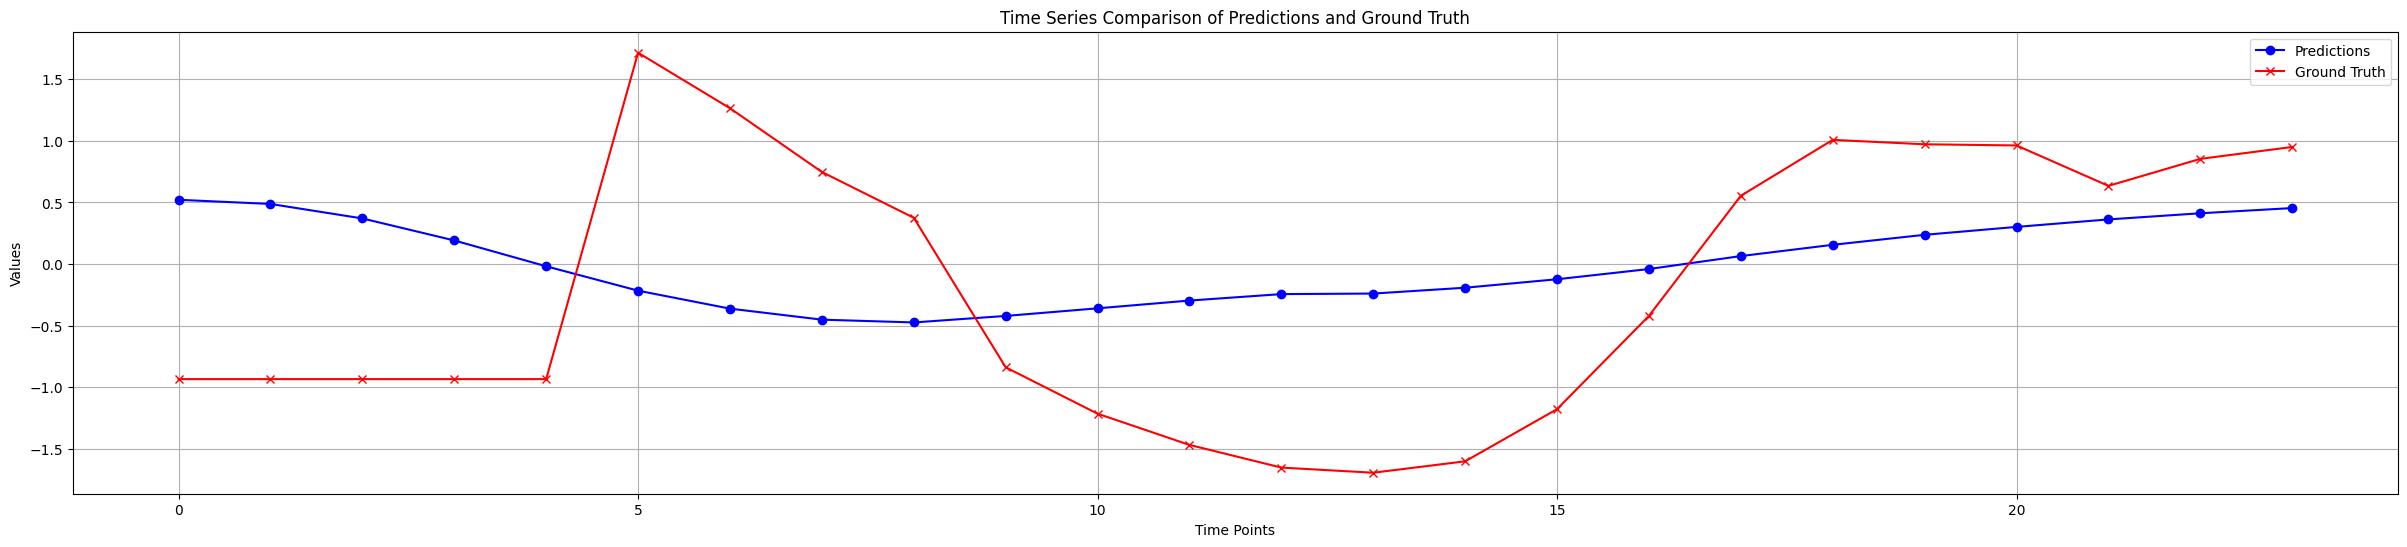

In [25]:
plt.figure(figsize=(30, 6))
plt.plot(predictions[155], label='Predictions', color='blue', marker='o') 
plt.plot(y_test[155], label='Ground Truth', color='red', marker='x')  


plt.title('Time Series Comparison of Predictions and Ground Truth')
plt.xlabel('Time Points')
plt.ylabel('Values')
plt.legend()

plt.grid(True)
plt.show()

In [26]:
pred = predictions.reshape(-1,1)
y_test_1d = y_test.reshape(-1,1)
print(len(pred))

245304


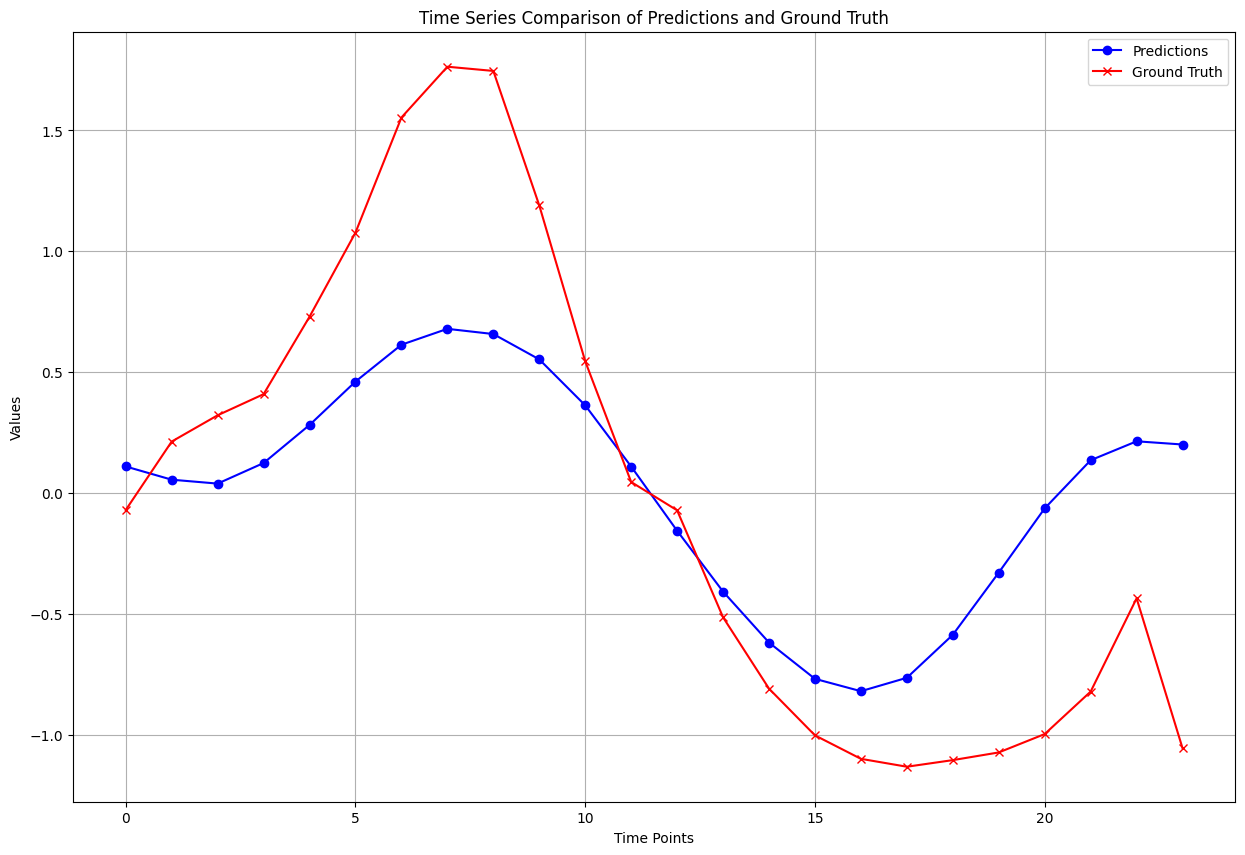

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(predictions[200], label='Predictions', color='blue', marker='o') 
plt.plot(y_test[200], label='Ground Truth', color='red', marker='x')

plt.title('Time Series Comparison of Predictions and Ground Truth')
plt.xlabel('Time Points')
plt.ylabel('Hourly Sum')
plt.legend()

plt.grid(True)
plt.show()


In [28]:
y_train_1d = y_train.reshape(-1,1)

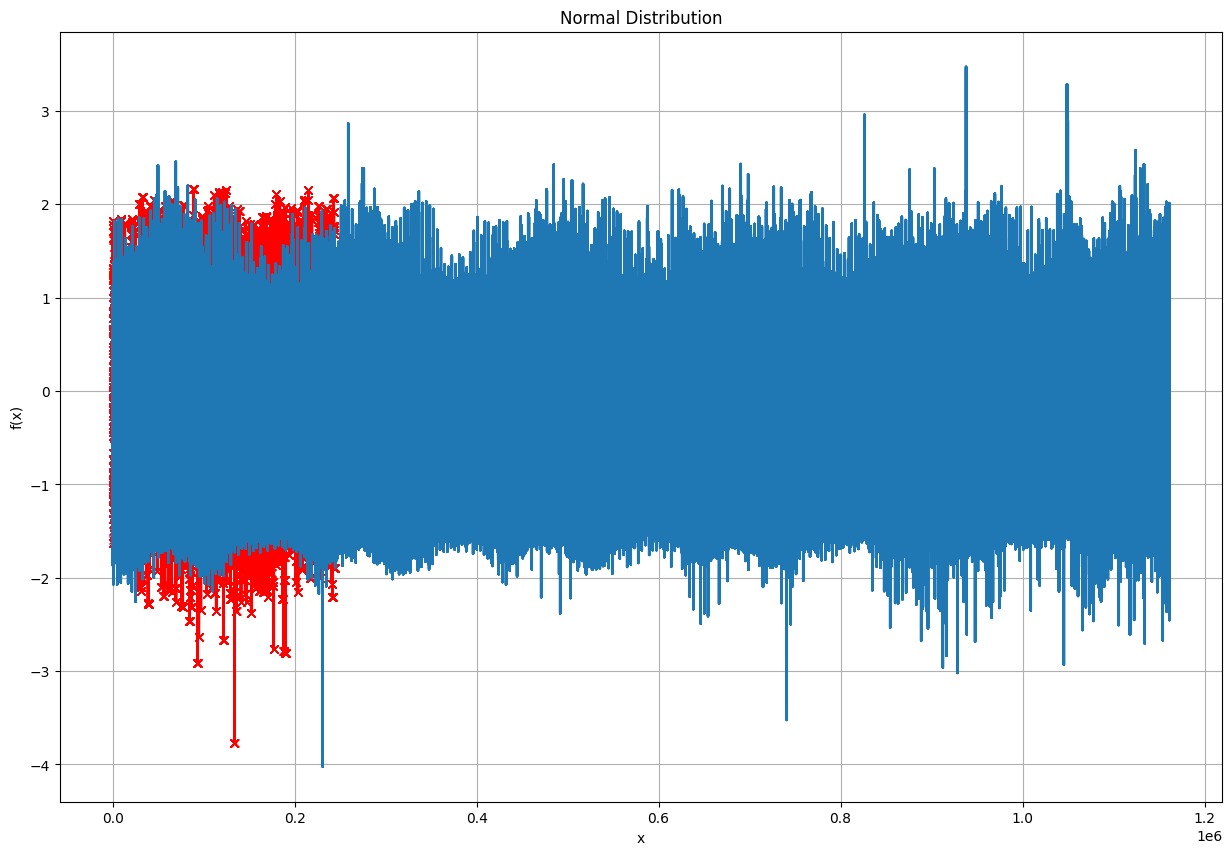

In [29]:
plt.figure(figsize=(15,10))
Time Series Comparison of Predictions and Ground Truth
plt.xlabel('Time Points')
plt.ylabel('Hourly Sum') 
plt.grid()
plt.plot(y_test_1d, label='Ground Truth', color='red', marker='x')
plt.plot(y_train_1d,label='Predictions', color='blue', marker='o') 
plt.show()